# Introduction

This project analyzes nighttime aircraft noise complaints around San Francisco International Airport (SFO) to understand which neighborhoods are most affected and what factors contribute to the disturbance.

Our analysis focuses on three objectives:

- Identifying the neighborhoods with the highest number of nighttime reports (8 PM–7 AM).

- Examining how aircraft type, altitude, operation type, hour of night, and season influence noise-related reporting patterns.

- Building a simple predictive model to estimate complaint levels from flight characteristics and to evaluate how changes in operations might reduce nighttime noise.

By cleaning, analyzing, and modeling SFO’s nighttime noise-complaint data, this project aims to provide insights that can help both residents and airport authorities address ongoing noise challenges more effectively.

# Data Source

We use the publicly available SFO Aircraft Noise Reports dataset from Data.gov : https://catalog.data.gov/dataset/sfo-aircraft-noise-reports. 
This dataset records every noise complaint submitted by residents living near SFO from 2018 to the present.
For our project, we focus specifically on night-time complaints (8 PM–7 AM) and extract variables such as:

- Disturbance date and time

- Reporter’s city and postal code

- Aircraft altitude

- Aircraft type

- Operation type (Arrival/Departure)

- Airport ID

- Hour of disturbance

Before analysis or modeling, the dataset requires substantial cleaning to remove irrelevant entries, fix date formats, handle missing values, and reduce the file size.

# Data Preparation
## 1. Load libraries and dataset

We first import Python libraries that we will use throughout the project:

pandas → data manipulation

numpy → numerical operations

matplotlib and seaborn → visualizations

We then load the dataset into a DataFrame to begin exploration.

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")

In [88]:
df = pd.read_csv("../data/Aircraft_Noise_Reports.csv")
df.head()


/var/folders/wx/0m6_v4n9285892l822ksy8740000gn/T/ipykernel_70276/4083608527.py:1: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/Aircraft_Noise_Reports.csv")


,disturbance_date_time,report_method,corr_id,reporter_city,reporter_postal_code,aircraft_pca_altitude,airport_id,operation_type,runway_name,flight_no,aircraft_type,destination_origin,data_as_of,data_loaded_at
0,2024/08/18 07:21:21 PM,Email,20662792,Palo Alto,94301,4911.0,SFO,A,28L,AAL2165,A319,LAX,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
1,2024/08/18 07:21:42 PM,AWA App,20662333,Portola Valley,94028,4610.0,SFO,A,28L,ASA129,B739,LAS,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
2,2024/08/18 07:21:46 PM,AWA App,20662792,Palo Alto,94303,4803.0,SFO,A,28L,AAL2165,A319,LAX,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
3,2024/08/18 07:24:40 PM,AWA App,20663178,Redwood City,94061,4390.0,SFO,A,28R,UAL1947,B39M,HNL,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
4,2024/09/13 07:09:59 PM,AWA App,20692087,Santa Cruz,95065,11378.0,SFO,A,28L,UAL2320,B739,LAX,2024/11/07 05:04:54 PM,2025/10/07 06:22:50 AM


This allows us to inspect the dataset and see the first few records. It gives an overview of which columns are available and the general structure of the data.

## 2. Remove Unecessary columns

The raw dataset contains many fields we do not need for our analysis.
By keeping only the columns relevant to our project, we reduce memory usage and simplify the dataset.

In [89]:

columns_to_load = [
    'disturbance_date_time', 'reporter_city', 'reporter_postal_code',
    'aircraft_pca_altitude', 'airport_id', 'operation_type', 'aircraft_type'
]


## 3. Filter for SFO and Valid Operation Types

We are only interested in complaints from SFO, and for flights that are arrivals (A) or departures (D).

In [90]:

df = df[(df['airport_id'] == 'SFO') & (df['operation_type'].isin(['A', 'D']))]


Filtering ensures we are not analyzing irrelevant airports or invalid operation types, which keeps our results accurate.

## 4. Convert Disturbance Date-Time Format

The timestamp is originally a string. We convert it to a datetime object so we can extract useful features like hour and season.

In [91]:
df['disturbance_date_time'] = pd.to_datetime(
    df['disturbance_date_time'],
    format="%Y/%m/%d %I:%M:%S %p",  # note %I for 12-hour and %p for AM/PM
    errors='coerce'
)
df = df.dropna(subset=['disturbance_date_time'])

errors='coerce' ensures that any invalid date strings become NaT, which we then remove. This avoids errors in further processing.

## 5. Extract Hour and Filter for Night-Time

We extract the hour of the disturbance and keep only complaints between 20:00 and 07:00.

In [92]:
df['hour'] = df['disturbance_date_time'].dt.hour
df = df[(df['hour'] >= 20) | (df['hour'] <= 7)]

Filtering to night-time focuses our analysis on the period most relevant for sleep disturbance.

## 6. Remove Duplicates and Keep Useful Columns

We remove duplicates to avoid double-counting complaints and reset the index for easier handling. Then we keep only the columns necessary for analysis.

In [93]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [94]:
columns_needed = [
    'disturbance_date_time', 'reporter_city', 'reporter_postal_code',
    'aircraft_pca_altitude', 'airport_id', 'operation_type', 'aircraft_type', 'hour'
]

df = df[columns_needed]

## 7. Save Cleaned Dataset

We save the cleaned dataset for later use.

In [95]:
df.to_csv("../data/Cleaned_Aircraft_Noise_Night_SFO.csv", index=False)

print("Cleaned dataset saved to data/Cleaned_Aircraft_Noise_Night_SFO.csv")

Cleaned dataset saved to data/Cleaned_Aircraft_Noise_Night_SFO.csv


In [96]:
df.head()

,disturbance_date_time,reporter_city,reporter_postal_code,aircraft_pca_altitude,airport_id,operation_type,aircraft_type,hour
0,2024-08-18 20:03:17,Portola Valley,94028,5007.0,SFO,D,B77W,20
1,2024-08-18 20:13:19,Los Altos Hills,94024,6644.0,SFO,A,E75L,20
2,2024-08-18 20:12:53,Mountain View,94040,6296.0,SFO,A,E75L,20
3,2024-08-18 20:10:30,San Francisco,94124,4678.0,SFO,D,B738,20
4,2024-08-18 20:15:16,Mountain View,94040,6296.0,SFO,A,E75L,20


## 8. Inspect Clean dataset and preparation

We check the structure, duplicates, and missing values to understand what further cleaning is needed.

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2025901 entries, 0 to 2025900
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   disturbance_date_time  datetime64[ns]
 1   reporter_city          object        
 2   reporter_postal_code   object        
 3   aircraft_pca_altitude  float64       
 4   airport_id             object        
 5   operation_type         object        
 6   aircraft_type          object        
 7   hour                   int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(5)
memory usage: 115.9+ MB


In [98]:
df.duplicated().sum()

np.int64(358)

Some duplicates are present, so we will remove them to ensure our analysis is accurate.

In [99]:
df = df.drop_duplicates()


## 9. Handle Missing Values

Inspect the remaining missing values

In [100]:
df.isna().sum().to_frame(name="Number of Missing Values")

,Number of Missing Values
disturbance_date_time,0
reporter_city,0
reporter_postal_code,3
aircraft_pca_altitude,461
airport_id,0
operation_type,0
aircraft_type,277
hour,0


We handle missing values carefully:

- Drop the few missing reporter postal codes

- Fill missing aircraft altitude with the median

- Fill missing aircraft type with 'Unknown'

In [101]:
df = df.dropna(subset=['reporter_postal_code'])

In [102]:
df['aircraft_pca_altitude'] = df['aircraft_pca_altitude'].fillna(df['aircraft_pca_altitude'].median())

In [103]:
df['aircraft_type'] = df['aircraft_type'].fillna('Unknown')

This ensures all relevant columns are complete, which is important for analysis and modeling. Altitude and aircraft type are meaningful for noise patterns, so imputing them preserves data integrity.

Check for the remaining missing value

In [104]:
df.isna().sum().to_frame(name="Number of Missing Values")

,Number of Missing Values
disturbance_date_time,0
reporter_city,0
reporter_postal_code,0
aircraft_pca_altitude,0
airport_id,0
operation_type,0
aircraft_type,0
hour,0


There are no missing values remaining — the dataset is clean and ready for exploration.

# Exploratory Data Analysis

## 1. Complaints by city 
We first check the top 15 neighborhoods report the most noise complaints and the least complaints

In [105]:
complaints_by_city = (
    df.groupby('reporter_city').size().reset_index(name='complaint_count')
)
complaints_by_city = complaints_by_city.sort_values(by='complaint_count', ascending=False)

We visualize top 15 cities - Bar plot shows the top 15 most affected neighborhoods

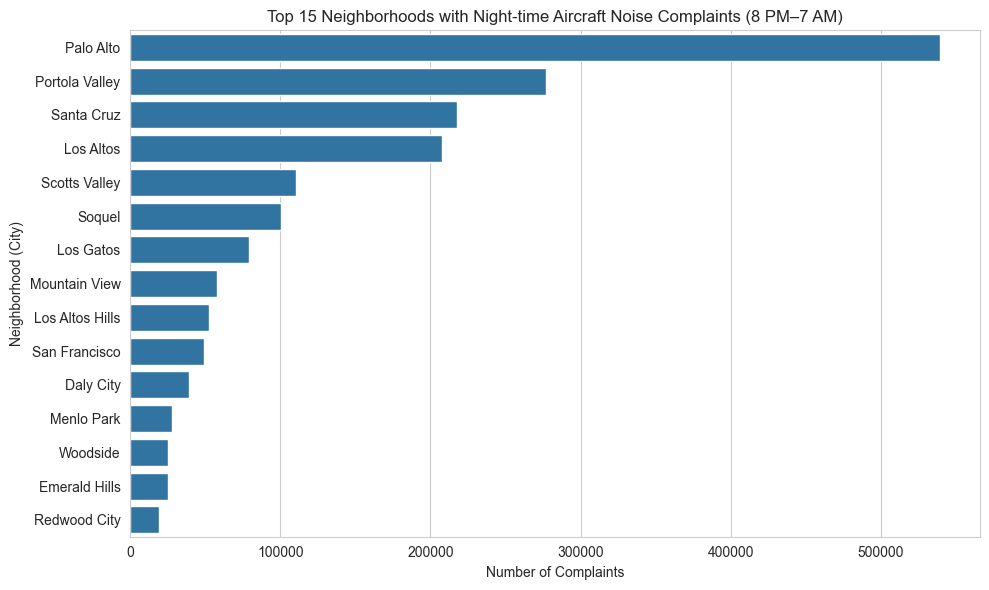

In [106]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=complaints_by_city.head(15),
    x="complaint_count",
    y="reporter_city"
)
plt.title("Top 15 Neighborhoods with Night-time Aircraft Noise Complaints (8 PM–7 AM)")
plt.xlabel("Number of Complaints")
plt.ylabel("Neighborhood (City)")
plt.tight_layout()
plt.show()


The Top 15 chart shows that night-time aircraft noise complaints are heavily concentrated in only a few neighborhoods. Palo Alto reports by far the highest number of complaints, followed by Portola Valley, Santa Cruz, and Los Altos. These cities experience significantly more disturbance than the rest of the neighborhoods on the list. The sharp drop after the top four suggests that specific flight paths and operational patterns affect certain communities much more than others.

Bar plot shows the least 15 Neighborhoods with Night-time Aircraft Noise Complaints (8PM - 7AM)

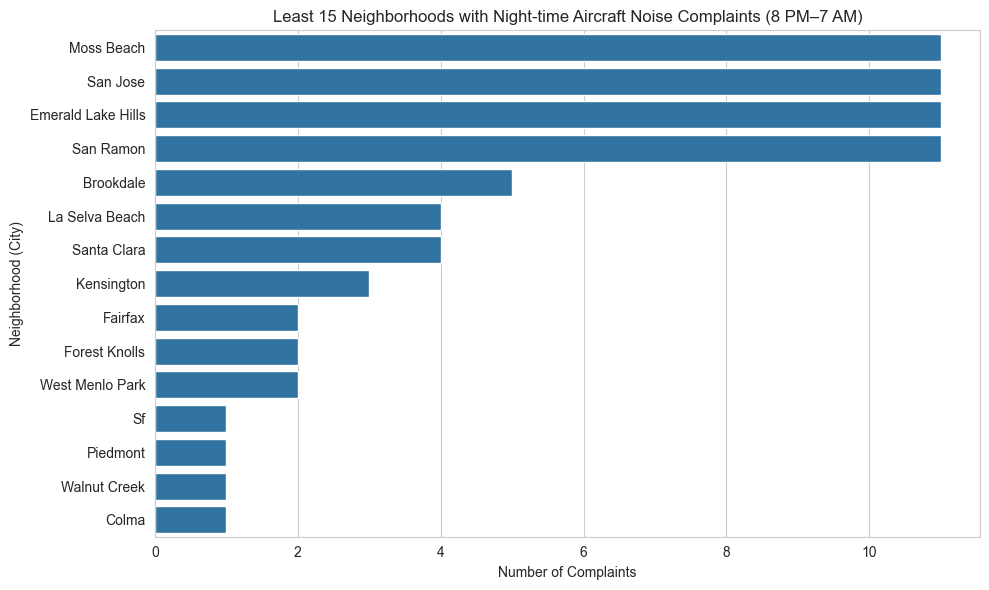

In [107]:
# Least 15 Neighborhoods with Night-time Aircraft Noise Complaints (8 PM–7 AM)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=complaints_by_city.tail(15),
    x="complaint_count",
    y="reporter_city",
    orient="h"
)

plt.title("Least 15 Neighborhoods with Night-time Aircraft Noise Complaints (8 PM–7 AM)")
plt.xlabel("Number of Complaints")
plt.ylabel("Neighborhood (City)")
plt.tight_layout()
plt.show()


Night-time aircraft noise complaints are highly concentrated in a few neighborhoods. Palo Alto, Portola Valley, Santa Cruz, and Los Altos report the highest volumes, while the Least 15 neighborhoods, like Walnut Creek and Piedmont, register almost no complaints. This shows the issue is localized, severely affecting only specific communities along busy flight paths.

## 2. Altitude Distribution

We explore whether the altitude of aircraft contributes to complaints using the box plot.

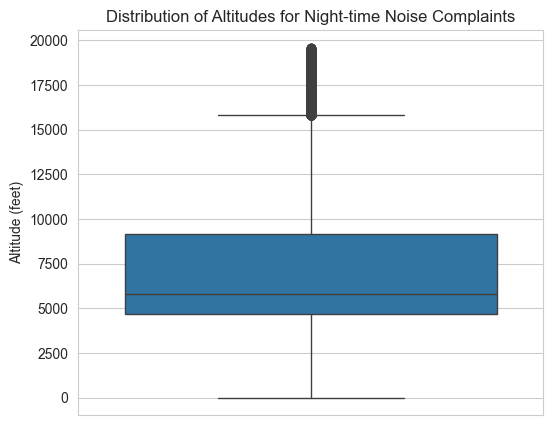

In [108]:
df_alt = df.dropna(subset=['aircraft_pca_altitude'])
df_alt = df_alt[df_alt['aircraft_pca_altitude'] > 0]

plt.figure(figsize=(6,5))
sns.boxplot(data=df_alt, y="aircraft_pca_altitude")
plt.title("Distribution of Altitudes for Night-time Noise Complaints")
plt.ylabel("Altitude (feet)")
plt.show()


The box plot shows that the higher the altitude of flights, the more night-time noise complaints they tend to generate, with most complaints coming from aircraft between 4,500 and 9,000 feet. These higher-altitude flights mainly affect neighborhoods like Palo Alto, Portola Valley, Santa Cruz, and Los Altos, which explains why they report the most complaints.

## 3. Complaints by Aircraft Type

We count complaints for each aircraft type and visualize the top 10 most and least complaint-generating types.

In [109]:
complaints_by_aircraft = (
    df.groupby('aircraft_type')
      .size()
      .reset_index(name='num_complaints')
      .sort_values(by='num_complaints', ascending=False)
)

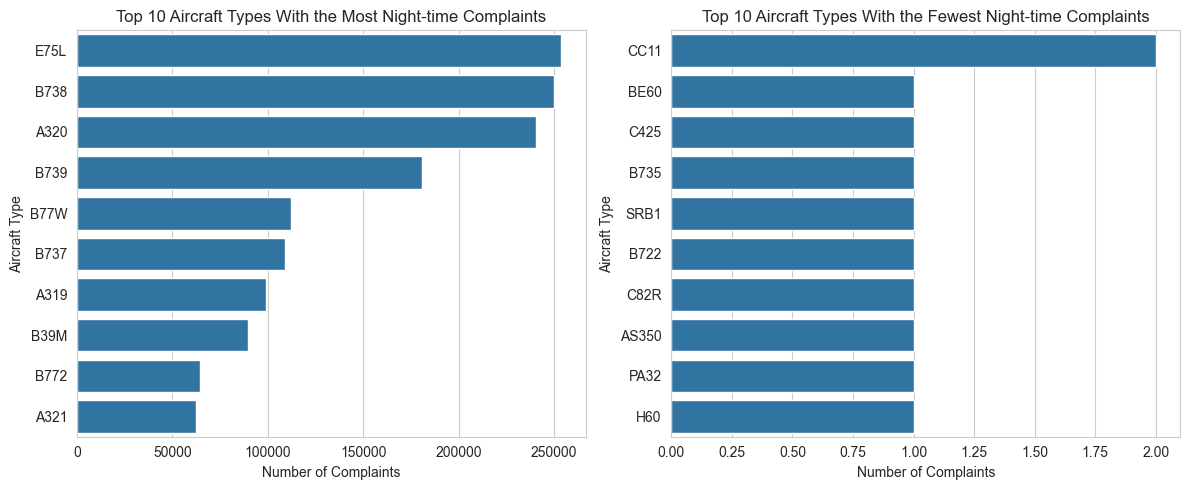

In [110]:
# Take top 10 aircraft types by number of complaints
top10_high = complaints_by_aircraft.head(10)
top10_low = complaints_by_aircraft.tail(10)


plt.figure(figsize=(12,5))

# Top 10 highest
plt.subplot(1,2,1)
sns.barplot(data=top10_high, x='num_complaints', y='aircraft_type')
plt.title("Top 10 Aircraft Types With the Most Night-time Complaints")
plt.xlabel("Number of Complaints")
plt.ylabel("Aircraft Type")

# Top 10 lowest
plt.subplot(1,2,2)
sns.barplot(data=top10_low, x='num_complaints', y='aircraft_type')
plt.title("Top 10 Aircraft Types With the Fewest Night-time Complaints")
plt.xlabel("Number of Complaints")
plt.ylabel("Aircraft Type")

plt.tight_layout()
plt.show()

The majority of night-time complaints come from a few large commercial jets—E75L, B738, and A320—each generating close to 250,000 complaints. Other large jets in the top 10 still produce tens of thousands of complaints, while most other aircraft types generate almost no complaints, often fewer than 2. This shows that a small number of aircraft types are responsible for nearly all complaints, while the majority of aircraft contribute minimally.

## 4. Complaint by night hours

We will count complaints for each night hour (8 PM–7 AM), plot them in order, and identify the peak and lowest complaint hours.

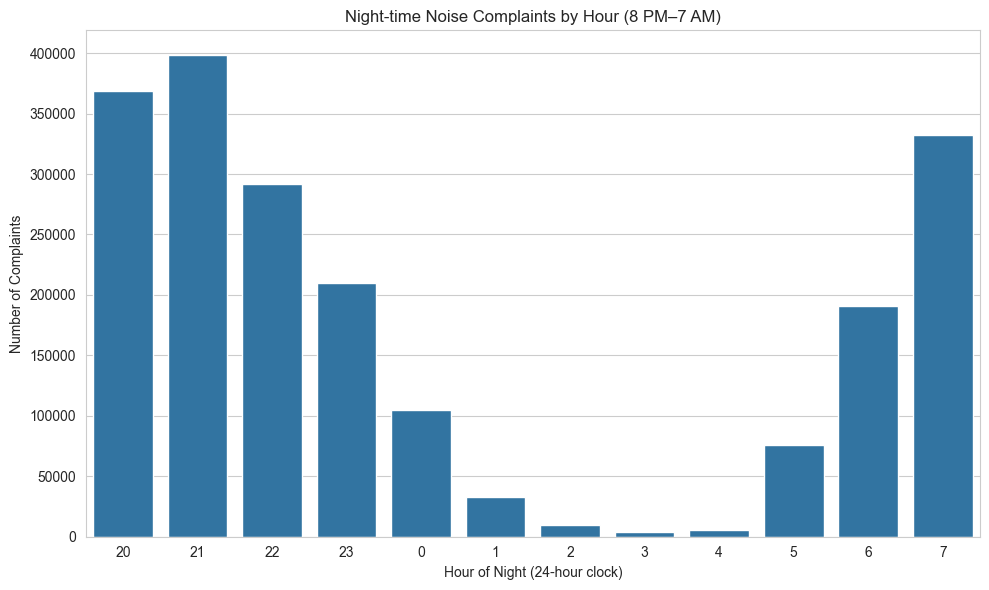

Hour with MOST complaints: 21 with 398842 complaints
Hour with LEAST complaints: 3 with 3782 complaints


In [111]:
# Count complaints for each hour in the night period
complaints_by_hour = (
    df.groupby('hour')
      .size()
      .reset_index(name='num_complaints')
      .sort_values(by='hour')
)
# Count complaints for each hour in the night period
# Define the night hours in order
night_hours = [20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7]

# Make 'hour' a categorical variable with this order
complaints_by_hour['hour'] = pd.Categorical(
    complaints_by_hour['hour'],
    categories=night_hours,
    ordered=True
)

plt.figure(figsize=(10,6))
sns.barplot(data=complaints_by_hour, x='hour', y='num_complaints')
plt.title("Night-time Noise Complaints by Hour (8 PM–7 AM)")
plt.xlabel("Hour of Night (24-hour clock)")
plt.ylabel("Number of Complaints")
plt.tight_layout()
plt.show()

most = complaints_by_hour.loc[complaints_by_hour['num_complaints'].idxmax()]
least = complaints_by_hour.loc[complaints_by_hour['num_complaints'].idxmin()]

print("Hour with MOST complaints:", int(most['hour']), "with", int(most['num_complaints']), "complaints")
print("Hour with LEAST complaints:", int(least['hour']), "with", int(least['num_complaints']), "complaints")


The plot revealed that complaints are highest in the early evening (8–9 PM) and early morning (6–7 AM), likely because people are trying to sleep or wake up. Between 2 AM and 4 AM, complaints drop sharply, probably due to both fewer flights operating and most residents being asleep.

## 5. Complaint by seasonal

We want to understand how night-time complaints are distributed across the four seasons by using pie chart.

In [112]:
# Function to assign season
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

# Create a new 'season' column
df['season'] = df['disturbance_date_time'].dt.month.apply(month_to_season)


# Count complaints by season
complaints_by_season = df['season'].value_counts().reindex(['Winter','Spring','Summer','Fall'])



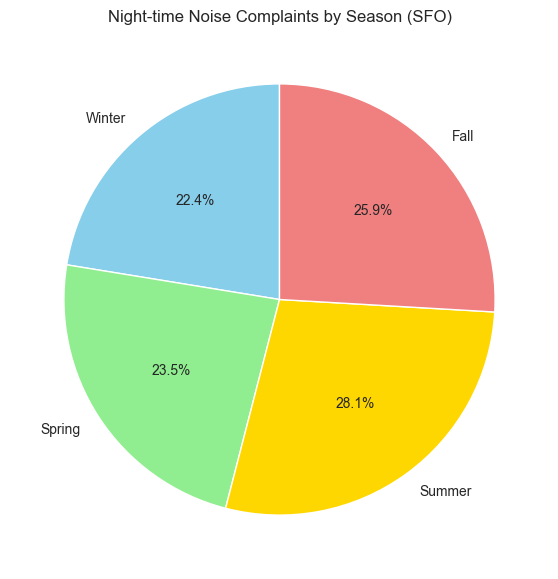

In [113]:
plt.figure(figsize=(7,7))
plt.pie(
    complaints_by_season,
    labels=complaints_by_season.index,
    autopct='%1.1f%%',  # show percentages
    colors=['skyblue','lightgreen','gold','lightcoral'],
    startangle=90
)
plt.title("Night-time Noise Complaints by Season (SFO)")
plt.show()



Night-time complaints are slightly higher in Summer (28.1%) and Fall (25.9%), and lowest in Winter (22.4%). This suggests that residents may be more aware of aircraft noise during the warmer months, possibly because windows are open or people spend more time at home, while in Winter, complaints drop when homes are more insulated or people are less active outdoors.

## 6. COMPLAINTS BY OPERATION TYPE

We want to understand whether arrivals or departures generate more night-time complaints using pie chart.

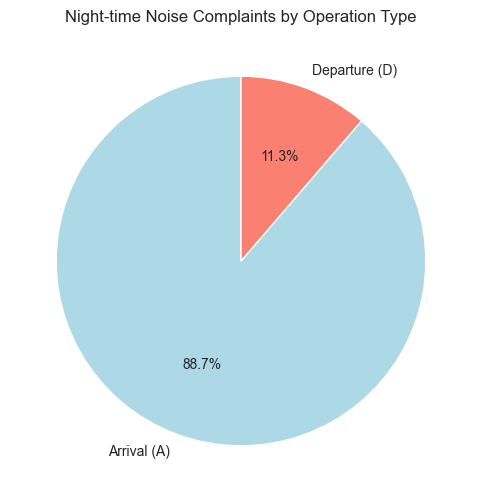

In [114]:
complaints_by_operation = df['operation_type'].value_counts().reindex(['A','D'])
plt.figure(figsize=(6,6))
plt.pie(
    complaints_by_operation,
    labels=['Arrival (A)', 'Departure (D)'],
    autopct='%1.1f%%',
    colors=['lightblue','salmon'],
    startangle=90
)
plt.title("Night-time Noise Complaints by Operation Type")
plt.show()


The vast majority of night-time complaints (88.7%) come from arriving aircraft, while departures account for only 11.3%. This suggests that arrivals are generally noisier or more disruptive to residents, making them the primary driver of complaints.

# Modeling Night-Time Aircraft Noise Complaints

In this section, we build a predictive model to estimate the number of night-time aircraft noise complaints per neighborhood and test “what-if” scenarios such as increasing aircraft altitude. We use CatBoost Regressor because it efficiently handles both numerical and categorical features, requires minimal preprocessing for categorical variables, and performs well on non-linear and skewed data.

Our features include:

- Categorical: aircraft_type, operation_type

- Numerical: aircraft_pca_altitude, distance_to_sfo_km, population

- Time features: Cyclical transformations of hour and a late-night indicator

### Import library

In [115]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
import seaborn as sns



### Load and Prepare Dataset

We load the aircraft noise complaints dataset and the ZIP code latitude/longitude data to compute distances from each reporter’s location to SFO. Distance is included because neighborhoods closer to the airport generally report more complaints.

In [116]:
# Load complaint dataset
df = pd.read_csv("../data/Cleaned_Aircraft_Noise_Night_SFO.csv")
df['reporter_postal_code'] = df['reporter_postal_code'].astype(str).str.zfill(5)
df['hour'] = df['hour'].astype(int)
df['aircraft_type'] = df['aircraft_type'].astype(str)
df['operation_type'] = df['operation_type'].astype(str)

# Load ZIP lat/lon and population data
zip_df = pd.read_csv("../data/uszips.csv")
zip_df['zip'] = zip_df['zip'].astype(str).str.zfill(5)

# Merge to include lat/lon and population
df = df.merge(
    zip_df[['zip','lat','lng','population']],
    left_on='reporter_postal_code',
    right_on='zip',
    how='left'
)


/var/folders/wx/0m6_v4n9285892l822ksy8740000gn/T/ipykernel_70276/3953240156.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/Cleaned_Aircraft_Noise_Night_SFO.csv")


### Compute Distance to SFO

We calculate the distance from each reporter to SFO using the Haversine formula. This gives the model a feature for proximity to the airport.

In [117]:
def haversine(lat1, lon1, lat2=37.6213, lon2=-122.3790):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(np.sqrt(a))
    r = 6371
    return c * r

df['distance_to_sfo_km'] = df.apply(lambda x: haversine(x['lat'], x['lng']), axis=1)


### Aggregate Complaints

We group the data by city, hour, operation type, and aircraft type, then compute average altitude, distance, population, and complaint counts. This creates a clean, structured dataset for modeling.

In [118]:
agg = df.groupby(['reporter_city', 'hour', 'operation_type', 'aircraft_type']).agg({
    'aircraft_pca_altitude': 'mean',
    'distance_to_sfo_km': 'mean',
    'population': 'mean'
}).reset_index()

agg['complaint_count'] = df.groupby(['reporter_city', 'hour', 'operation_type', 'aircraft_type']).size().values


### Feature Engineering

We create features to help the model capture temporal patterns and nighttime effects:

- Cyclical hour features: hour_sin and hour_cos encode the circular nature of hours

- Late-night indicator: is_late_night marks complaints from 8 PM to 7 AM

In [119]:
agg['hour_sin'] = np.sin(2*np.pi*agg['hour']/24)
agg['hour_cos'] = np.cos(2*np.pi*agg['hour']/24)
agg['is_late_night'] = agg['hour'].apply(lambda x: 1 if x>=20 or x<=4 else 0)


### Prepare Model Inputs

Categorical features are converted to category type. The target complaint_count is log-transformed to reduce skewness.

In [120]:
categorical_cols = ['operation_type','aircraft_type']
for col in categorical_cols:
    agg[col] = agg[col].astype('category')

agg['log_complaints'] = np.log1p(agg['complaint_count'])

features = ['aircraft_pca_altitude', 'distance_to_sfo_km', 'population',
            'hour_sin','hour_cos','is_late_night','operation_type','aircraft_type']
X = agg[features]
y = agg['log_complaints']


### Train CatBoost Model

We train using 5-fold cross-validation and evaluate using R² and MAE on the original scale

In [ ]:
model = CatBoostRegressor(
    iterations=500,
    depth=10,
    learning_rate=0.1,
    loss_function='RMSE',
    random_seed=42,
    verbose=100,
    task_type='CPU'
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores, mae_scores = [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
   
    model.fit(X_train, y_train, cat_features=categorical_cols, verbose=False)
    y_pred = model.predict(X_test)
    
    y_pred_orig = np.expm1(y_pred)
    y_test_orig = np.expm1(y_test)
    
    r2_scores.append(r2_score(y_test_orig, y_pred_orig))
    mae_scores.append(mean_absolute_error(y_test_orig, y_pred_orig))

print("Mean R²:", np.mean(r2_scores))
print("Mean MAE:", np.mean(mae_scores))


Mean R²: 0.5896602116600531
Mean MAE: 57.953525442555794


### Scenario Analysis

We test the impact of increasing aircraft altitude by 1,000 ft on predicted complaints.

     reporter_city  avg_change_in_complaints
0       Santa Cruz               -157.854768
1        Palo Alto               -127.135380
2           Soquel                -69.155734
3        Los Altos                -63.972602
4    Scotts Valley                -42.925775
5  Los Altos Hills                -35.791936
6   Portola Valley                -25.153405
7    Mountain View                -23.126804
8        Los Gatos                -16.407299
9      Foster City                -13.555902


/var/folders/wx/0m6_v4n9285892l822ksy8740000gn/T/ipykernel_70276/868802896.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


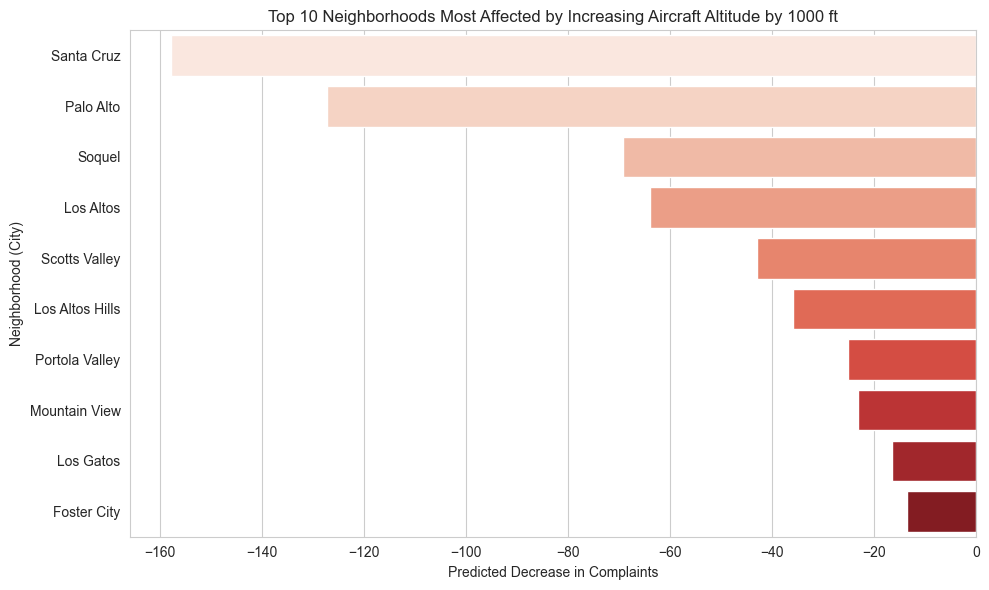

In [122]:
X_scenario = X.copy()
X_scenario['aircraft_pca_altitude'] += 1000

y_scenario_pred = model.predict(X_scenario)
y_scenario_pred_orig = np.expm1(y_scenario_pred)
y_orig_pred = np.expm1(model.predict(X))

agg['predicted_change'] = y_scenario_pred_orig - y_orig_pred

top10_neighborhoods = agg.groupby('reporter_city')['predicted_change'].mean().nsmallest(10).reset_index()
top10_neighborhoods.columns = ['reporter_city','avg_change_in_complaints']
top10_neighborhoods = top10_neighborhoods.sort_values(by='avg_change_in_complaints')

print(top10_neighborhoods)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top10_neighborhoods,
    x='avg_change_in_complaints',
    y='reporter_city',
    palette=sns.color_palette("Reds", n_colors=top10_neighborhoods.shape[0])
)
plt.title("Top 10 Neighborhoods Most Affected by Increasing Aircraft Altitude by 1000 ft")
plt.xlabel("Predicted Decrease in Complaints")
plt.ylabel("Neighborhood (City)")
plt.tight_layout()
plt.show()


The plot shows predicted reductions in complaints if altitude is increased. Santa Cruz sees the largest drop (~158 fewer complaints), while Emerald Hills sees the smallest (~14 fewer complaints). This highlights how operational changes can reduce noise impact for neighborhoods most affected by low-flying aircraft.